# Lesson 4.2 逻辑回归的参数估计：极大似然估计，相对熵与交叉熵损失函数

在模型基本结构构建完成之后，接下来我们开始讨论如何进行逻辑回归的参数估计。所谓参数估计，其实就是模型参数求解的更加具有统计风格的称呼。根据逻辑回归的基本公式：

$$
y=\frac{1}{1+e^{-\left(\hat{w}^T \cdot \hat{x}\right)}}
$$

不难看出，逻辑回归的参数其实就是线性方程中的自变量系数和截距。不过由于加入了联系函数，逻辑回归的参数并不能像线性回归一样利用最小二乘法进行快速求解。

当然，和所有机器学习模型一样，要求解模型参数，就必须构造损失函数，然后根据损失函数的基本情况寻找优化算法求解。对于逻辑回归来说，课上将介绍两种不同的方法来创建和求解损失函数，两种方法出发点各不相同但却殊途同归：分别是极大似然估计和通过相对熵构建交叉熵损失函数。

In [1]:
# 科学计算模块
import numpy as np
import pandas as pd

# 画图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# 自定义模块
from ML_basic_function import *

## 一、逻辑回归参数估计基本思路

比较有趣的一点是，尽管逻辑回归的损失函数构建过程比较复杂，但逻辑回归的损失函数的基本形式比较容易理解。因此首先我们先通过一个简单的例子来讨论关于逻辑回归的参数估计的基本思路，即损失函数构建和求解的一般思路。

### 1. 构建损失函数

现有简单数据集如下：

| sepal_length | species |
|---|:---|
| 1 | 0 |
| 3 | 1 |


由于只有一个特征，因此可以构建逻辑回归模型为：

$$
y=\operatorname{sigmoid}(w x+b)=\frac{1}{1+e^{-(w x+b)}}
$$

我们将模型输出结果视作概率，则分别带入两条数据可得模型输出结果为：

$$
\begin{aligned}
& p(y=1 \mid x=1)=\frac{1}{1+e^{-(w+b)}} \\
& p(y=1 \mid x=3)=\frac{1}{1+e^{-(3 w+b)}}
\end{aligned}
$$

其中p(y=1 | x=1)表示x取值为1时y取值为1的条件概率。而我们知道，两条数据的真实情况为第一条数据y取值为0，而第二条数据y取值为1，因此我们可以计算p(y=0 | x=1)如下：

$$
p(y=0 \mid x=1)=1-p(y=1 \mid x=1)=1-\frac{1}{1+e^{-(w+b)}}=\frac{e^{-(w+b)}}{1+e^{-(w+b)}}
$$

一般来说，损失函数的构建目标和模型评估指标保持一致(例如SSELoss和SSE),对于大多数分类模型来说，模型预测的准确率都是最基础的评估指标。此处如果我们希望模型预测结果尽可能准确，就等价于希望p(y=0 | x=1)和p(y=1 | x=3)两个概率结果越大越好。该目标可以统一在求下式最大值的过程中：

$$
p(y=0 \mid x=1) \cdot p(y=1 \mid x=3)
$$

即我们希望x取1时y取0，和x取3时y取1的同时发生的概率越大越好。

此外，考虑到损失函数一般都是求最小值，因此可将上式求最大值转化为对应负数结果求最小值，同时累乘也可以转化为对数相加结果，因此上式求最大值可等价于下式求最小值：

$$
\begin{aligned}
\operatorname{Logit} \operatorname{Loss}(w, b) & =-\ln (p(y=1 \mid x=3))-\ln (p(y=0 \mid x=1)) \\
& =-\ln \left(\frac{1}{1+e^{-(3 w+b)}}\right)-\ln \left(\frac{e^{-(w+b)}}{1+e^{-(w+b)}}\right) \\
& =\ln \left(1+e^{-(3 w+b)}\right)+\ln \left(1+\frac{1}{e^{-(w+b)}}\right) \\
& =\ln \left(1+e^{-(3 w+b)}+e^{(w+b)}+e^{-2 w}\right)
\end{aligned}
$$

至此，我们即构建了一个由两条数据所构成的逻辑回归损失函数。

> 回顾此前课程内容：损失函数和带入数据量息息相关。

注意，在上述损失函数的构建过程中有两个关键步骤，需要再次提醒。

其一时将模型高准确率的诉求具象化为$ p (y=0 | x=1)·p(y=1 | x=3)$参数的过程，此处我们为何不能采用类似SSE的计算思路去构建损失函数，即进行如下运算：

$$
\|y-y h a t\|_2^2=\left\|y-\frac{1}{1+e^{-(\hat{\hat{w}} \cdot \vec{x})}}\right\|_2^2
$$

我们一般不会采用该方法构建损失函数，其根本原因在于，在数学层面上我们可以证明，对于逻辑回归，当y属于0-1分类变量时，$\|y-y h a t\|_2^2$ 损失函数并不是凸函数，而非凸的损失函数将对后续参数最优求解造成很大麻烦。而相比之下，概率连乘所构建的损失函数是凸函数，可以快速求解出全域最小值。

其二，在构建损失函数的过程中，我们需要将概率连乘改为对数累加，有一个很重要的原因是，在实际建模运算过程中，尤其是面对大量数据进行损失函数构建过程中，由于有多少条数据就要进行多少次累乘，而累乘的因子又是介于（0，1）之间的数，因此极有可能累乘得到一个非常小的数字，而通用的计算框架计算精度有限，极有可能在累乘过程中损失大量精度，而转化为对数累加之后能很好的避免该问题的发生。

### 2.损失函数求解

从数学角度可以证明，按照上述构成构建的逻辑回归损失函数仍然是凸函数，此时我们仍然可以通过对LogitLos5s(w,b)求偏导然后令偏导函数等于0、再联立方程组的方式来对参数进行求解。

$$
\begin{aligned}
& \frac{\partial \operatorname{Logit} \operatorname{Loss}(w, b)}{\partial w}=0 \\
& \frac{\partial \operatorname{Logit} \operatorname{Loss}(w, b)}{\partial b}=0
\end{aligned}
$$

值得一提的是，上述构建损失函数和求解损失函数的过程，也被称为极大似然估计。接下来我们就将极大似然估计的方法推广到一般过程。

## 二、利用极大似然估计进行参数估计

接下来，我们考虑更为一般的情况，围绕逻辑回归方程的一般形式，采用极大似然估计方法进行参数估计：

逻辑回归模型：

$$
y=\frac{1}{1+e^{-\left(\hat{w}^T \cdot \hat{x}\right)}}
$$

其中：

$$
\hat{w}=\left[w_1, w_2, \ldots w_d, b\right]^T, \hat{x}=\left[x_1, x_2, \ldots x_d, 1\right]^T
$$

求解过程总共分为四个步骤，分别是：

* Step 1.确定似然项

所谓似然函数，可简单理解为前例中累乘的函数。而累乘过程中的每个项，可称为似然项，不难发现，似然项其实和数据是一对应的，带入多少条数据进行建模，似然函数中就有多少个似然项。

我们知道，对于逻辑回归来说，当$\hat{w}$ 和$\hat{x}$取得一组之后，既可以有一个概率预测输出结果，即：

$$
p(y=1 \mid \hat{x} ; \hat{w})=\frac{1}{1+e^{-\left(\hat{w}^T \cdot \hat{x}\right)}}
$$

而对应y取0的概率为：

$$
1-p(y=1 \mid \hat{x} ; \hat{w})=1-\frac{1}{1+e^{-\left(\hat{w}^T \cdot \hat{x}\right)}}=\frac{e^{-\left(\hat{w}^T \cdot \hat{x}\right)}}{1+e^{-\left(\hat{w}^T \cdot \hat{x}\right)}}
$$

我们可以令

$$
\begin{gathered}
p_1(\hat{x} ; \hat{w})=p(y=1 \mid \hat{x} ; \hat{w}) \\
p_0(\hat{x} ; \hat{w})=1-p(y=1 \mid \hat{x} ; \hat{w})
\end{gathered}
$$

因此，第 i 个数据所对应的似然项可以写成：

$$
p_1(\hat{x} ; \hat{w})^{y_i} \cdot p_0(\hat{x} ; \hat{w})^{\left(1-y_i\right)}
$$

其中，$y_{i}$表示第i条数据对应的类别标签。不难发现，当$y_{i} = 0$ 时，代表的是第i条数据标签为0，此时需要带入似然函数的似然项是$p_0(\hat{x} ; \hat{w})$ （因为希望$p_{0}$ 的概率更大）。反之，当 $y_{i} = 1$ 时，代表的是第i条数据标签为1，此时需要带入似然函数的似然项是 $p_1(\hat{x} ; \hat{w})$。上述似然项可以同时满足这两种不同的情况。

* Step 2.构建似然函数

接下来，通过似然项的累乘计算极大似然函数：

$$
\prod_{i=1}^N\left[p_1(\hat{x} ; \hat{w})^{y_i} \cdot p_0(\hat{x} ; \hat{w})^{\left(1-y_i\right)}\right]
$$

* Step 3.进行对数转换

然后即可在似然函数基础上对其进行（以e为底的）对数转换，为了方便后续利用优化方法求解最小值，同样我们考虑构建负数对数似然函数：

$$
\begin{aligned}
L(\hat{w}) & =-\ln \left(\prod_{i=1}^N\left[p_1(\hat{x} ; \hat{w})^{y_i} \cdot p_0(\hat{x} ; \hat{w})^{\left(1-y_i\right)}\right]\right) \\
& =\sum_{i=1}^N\left[-y_i \cdot \ln \left(p_1(\hat{x} ; \hat{w})\right)-\left(1-y_i\right) \cdot \ln \left(p_0(\hat{x} ; \hat{w})\right)\right] \\
& =\sum_{i=1}^N\left[-y_i \cdot \ln \left(p_1(\hat{x} ; \hat{w})\right)-\left(1-y_i\right) \cdot \ln \left(1-p_1(\hat{x} ; \hat{w})\right)\right]
\end{aligned}
$$

公式推导至此即可，后续我们将借助该公式进行损失函数求解。

* Step 4.求解对数似然函数

通过一系列数学过程可以证明，通过极大似然估计构建的损失函数是凸函数，此时我们可以采用导数为0联立方程组的方式进行求解，这也是极大似然估计对参数求解的一般方法。但这种方法会涉及大量的导数运算、方程组求解等，并不适用于大规模甚至是超大规模数值运算，因此，在机器学习领域，我们通常会采用一些更加通用的优化方法对逻辑回归的损失函数进行求解，通常来说是牛顿法或者梯度下降算法，其中，梯度下降算法是机器学习中最为通用的求解损失函数的优化算法，我们将在下一小节花费一整节的时间侠进行介绍。本节我们将继续介绍另外一种推导逻辑回归损失函数的方法—KL离散度计算法，并介绍有关信息熵、交叉熵等关键概念。

> 由于模型本身和损失函数构建方式都和线性回归有所不同，逻辑回归的损失函数无法采用最小二乘法进行求解。

## 三、熵，相对熵与交叉熵

接下来，我们介绍另一种构建逻辑回归损失函数的基本思路————借助相对熵（relative entropy,又称KL离散度）构建损失函数。尽管最终损失函数构建结果和极大似然估计相同，但该过程所涉及到的关于信息熵(entropy)、相对熵等概念却是包括EM算法、决策树算法等诸多机器学习算法的理论基础。

### 1.熵

通常我们用熵(entropy)来表示随机变量不确定性的度量，或者说系统混乱程度、信息混乱程度。熵的计算公式如下：

$$
H(X)=-\sum_{i=1}^n p\left(x_i\right) \log \left(p\left(x_i\right)\right)
$$

其中，$p(x_{i})$ 表示多分类问题中第i个类别出现的概率，表示类别总数，通常来说信息熵的计算都取底数为2，并且规定 $ log 0 = 0$。举例说明信息熵计算过程，假设有二分类数据集1标签如下：

数据集1

| index | labels |
|---|:---|
| 1 | 0 |
| 2 | 1 |
| 3 | 1 |
| 4 | 1 |


则信息熵的计算过程中n=2,令p(x1)表示类别0的概率，p(x2)表示类别1的概率（反之亦然），则

$$
\begin{aligned}
& p\left(x_1\right)=\frac{1}{4} \\
& p\left(x_2\right)=\frac{3}{4}
\end{aligned}
$$

则该数据集的信息熵计算结果如下：

$$
\begin{aligned}
H(X) & =-\left(p\left(x_1\right) \log \left(p\left(x_1\right)\right)+p\left(x_2\right) \log \left(p\left(x_2\right)\right)\right) \\
& =-\left(\frac{1}{4}\right) \log \left(\frac{1}{4}\right)-\left(\frac{3}{4}\right) \log \left(\frac{3}{4}\right)
\end{aligned}
$$

In [2]:
-1/4 * np.log2(1/4) - 3/4 * np.log2(3/4)

0.8112781244591328

当然，我们也可以定义信息熵计算函数

In [3]:
def entropy(p):
    if p == 0 or p == 1:
        return 0
    else:
        return -p * np.log2(p) - (1-p) * np.log2(1-p)
    

简单测试函数性能

In [4]:
entropy(1/4)

0.8112781244591328

同时，在二分类问题中，$ n = 2$且 $p(x_{1}) + p(x_{2}) = 1$，我们也可以推导二分类的信息熵计算公式为:

$$
H(X)=-p(x) \log (p(x))-(1-p(x)) \log (1-p(x))
$$

其中，$p(x)$为样本标签为0或1的概率。

### 2. 熵的基本性质

可以证明，熵的计算结果在[0,1]之间，并且熵值越大，系统越混乱、信息越混乱。例如，有如下两个数据集其中数据集2总共4条样本，0、1类各占50%。

![Alt text](image-53.png)

对于该数据集，我们可以计算信息熵为

$$
H_1(X)=-\left(\frac{1}{2}\right) \log \left(\frac{1}{2}\right)-\left(\frac{1}{2}\right) \log \left(\frac{1}{2}\right)
$$

In [5]:
entropy(1/2)

1.0

此时信息熵达到最高值，也就代表对于上述二分类的数据集，标签随机变量的不确定性已经达到峰值

进一步我们计算下列数据集3的信息熵：

![Alt text](image-54.png)

信息熵计算可得：

$$
H_1(X)=-\left(\frac{4}{4}\right) \log \left(\frac{4}{4}\right)-\left(\frac{0}{4}\right) \log \left(\frac{0}{4}\right)=0
$$

此时信息熵取得最小值，也就代表标签的取值整体呈现非常确定的状态，系统信息规整。

> 值得一提的是，此时标签本身的信息量也为0，并没有进一步进行预测的必要。

结合上述三个数据集，不难看出，当标签取值不均时信息嫡较高，标签取值纯度较高时信息熵较低。假设为未分类数据集中1样本所占比例，则数据集信息嫡随着变化为变化趋势如下：

In [6]:
p = np.linspace(0, 1, 50)
ent_1 = [entropy(p_i) for p_i in p]

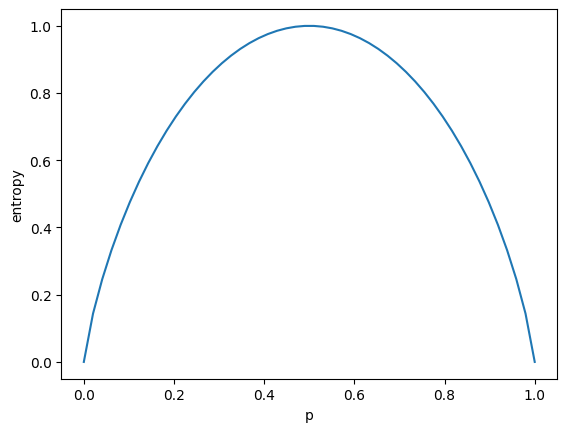

In [7]:
plt.plot(p, ent_1)
plt.xlabel('p')
plt.ylabel('entropy')
plt.show()

### 3. 相对熵(relative entropy)与交叉熵(cross entropy)

相对熵也被称为Kullback-Leibleri散度(KL散度)或者信息散度(information divergence),通常用来衡量两个随机变量分布的差异性。假设对同一个随机变量X,有两个单独的概率分布P(x)和Q(x),当X是离散变量时，我们可以通过如下相对熵计算公式来衡量二者差异：

$$
D_{K L}(P \| Q)=\sum_{i=1}^n P\left(x_i\right) \log \left(\frac{P\left(x_i\right)}{Q\left(x_i\right)}\right)
$$

和信息熵类似，相对熵越小，代表Q(x)和P(x)越接近。

从交叉熵的计算公式不难看出，这其实是一种非对称性度量，也就是  $D_{KL}(P || Q) ≠ D_{kL}(Q || P) $。从本质上来说，相对熵刻画的是用概率分布 $ Q $ 来刻画概率分布 $ P $ 的困难程度，而在机器学习领域，我们一般令$ Q $ 为模型输出结果，而 $ P $ 为数据集标签真实结果，以此来判断模型输出结果是否足够接近真实情况。

> Q为拟合分布P为真实分布，也被称为前向KL散度(forward KL divergence)

当然，上述相对熵公式等价于：

$$
\begin{aligned}
D_{K L}(P \| Q) & =\sum_{i=1}^n P\left(x_i\right) \log \left(\frac{P\left(x_i\right)}{Q\left(x_i\right)}\right) \\
& =\sum_{i=1}^n P\left(x_i\right) \log \left(P\left(x_i\right)\right)-\sum_{i=1}^n P\left(x_i\right) \log \left(Q\left(x_i\right)\right) \\
& =-H(P(x))+\left[-\sum_{i=1}^n P\left(x_i\right) \log \left(Q\left(x_i\right)\right)\right]
\end{aligned}
$$

而对于给定数据集，信息熵 $H（p(X)）$ 是确定的，因此相对熵的大小完全由$-\sum_{i=1}^n P\left(x_i\right) \log \left(Q\left(x_i\right)\right)$ 决定。而该式计算结果也被称为交叉熵(cross entropy)计算。

$$
\text{cross\_entropy}(P, Q) = -\sum_{i=1}^n P(x_i) \log(Q(x_i))
$$


因此，如果我们希望P、Q二者分布尽可能接近，我们就需要尽可能减少相对熵，但由于相对熵=交叉熵-信息熵，因此我们只能力求减少交叉熵。当然，也正因如此，交叉嫡可以作为衡量模型输出分布是否接近真实分布的重要度量方法。

简单总结上述过程要点：

* 我们使用相对熵 $ D_{KL}(P || Q)$ 来表示模型拟合分布Q和数据真实分布P之间的差距，相对熵越小，拟合效果越好；

* 根据计算公式，$D_{K L}(P \| Q)=-H(P(x))+\left[-\sum_{i=1}^n P\left(x_i\right) \log \left(Q\left(x_i\right)\right)\right]$ ,相对熵= 交叉熵-信息熵；

* 对于给定数据集，信息熵是确定的，因此我们只能通过尽可能减小交叉熵来降低相对熵；

> 根据吉布斯不等式，相对熵的取值恒大于零，当预测分布和真实分布完全一致时相对熵取值为0，此时交叉熵等于数据信息熵，此外只要二者分布不一致，交叉熵的取值都将大于信息熵。

## 四、交叉熵损失函数

* 单样本交叉熵计算

交叉熵的计算公式看似复杂，但实际运算过程比较简单，对于类似逻辑回归模型输出为连续变量，而真实标签为离散变脸的数据集，可以举例说明计算过程。例如有数据集情况如下：

![Alt text](image-55.png)

我们可以将其改写成如下形式：

![Alt text](image-57.png)

其中A、B表示每条样本可能所属的类别。围绕该数据集，第一条数据的交叉熵计算过程如下：

$$
\text{cross\_entropy} = -0 \cdot \log(0.2) - 1 \cdot \log(0.8)
$$


In [8]:
-np.log2(0.8)

0.3219280948873623

> 再次理解交叉熵计算公式中的叠加就是类别的叠加

> 上述数据集标签由0-1转化为A,B，也被称为名义型变量的独热编码。

而对于多个数据集，整体交叉熵实际上是每条数据交叉熵的均值。例如上述数据集，整体交叉嫡计算结果为：

$$
\frac{-1 * \log (0.8)-1 * \log (0.7)-1 * \log (0.6)-1 * \log (0.7)}{4}
$$

In [9]:
(-np.log2(0.8) - np.log2(0.7) - np.log2(0.6) - np.log2(0.7)) / 4

0.5220100086782713

据此，我们可以给出多样本交叉熵计算公式如下：

$$
\text{cross\_entropy} = -\frac{1}{m} \sum_{j=1}^m \sum_{i=1}^n p(p_{ij}) \log(q_{ij})
$$


其中m为数据量，n为类别数量。

* 对比极大似然估计函数

围绕上述数据集，如果考虑采用极大似然估计来进行计算，我们发现基本计算流程保持一致：

$$
L(\hat{w})=\sum_{i=1}^N\left[-y_i \cdot \ln \left(p_1(\hat{x} ; \hat{w})\right)-\left(1-y_i\right) \cdot \ln \left(1-p_1(\hat{x} ; \hat{w})\right)\right]
$$

带入数据可得：

$$
-\ln (0.8)-\ln (0.7)-\ln (0.6)-\ln (0.7)
$$

In [11]:
-np.log(0.8) - np.log(0.7) - np.log(0.6) - np.log(0.7)

1.4473190629576653

尽管具体数值计算结果有所差异，但基本流程都是类似的取类别1的概率的对数运算结果进行累加再取负数。因此在实际建模过程中，考虑采用极大似然估计构建损失函数，和采用交叉熵构建损失函数，效果是相同的，二者构建的损失函数都能很好的描绘模型预测结果和真实结果的差异程度。不过在机器学习领域，一般以交叉嫡损失函数为主。

* 二分类交叉熵损失函数

据此，我们也可最终推导二分类交叉熵损失函数计算公式，结合极大似然估计的计算公式和交叉熵的基本计算流程，二分类交叉嫡损失函数为：

$$
\operatorname{binary} C E(\hat{w})=-\frac{1}{n} \sum_{i=1}^N\left[y_i \cdot \log \left(p_1(\hat{x} ; \hat{w})\right)+\left(1-y_i\right) \cdot \log \left(1-p_1(\hat{x} ; \hat{w})\right)\right]
$$

我们也可以定义一个函数来进行二分类交叉嫡损失函数的计算：

In [15]:
def BCE(y, yhat):
    """二分类交叉熵损失函数
    y: 标签
    yhat: 预测值
    """
    return (-(1/len(y)) * np.sum(y * np.log2(yhat) + (1-y) * np.log2(1-yhat)))

简单进行验证

In [16]:
y = np.array([1, 0, 0, 1]).reshape(-1, 1)
yhat = np.array([0.8, 0.3, 0.4, 0.7]).reshape(-1, 1)

In [17]:
BCE(y, yhat)

0.5220100086782713

至此，我们就完成了完整的逻辑回归损失函数的构建。但正如此前所讨论的一样，对于逻辑回归的损失函数来说，尽管也是凸函数，但无法使用最小二乘法进行求解。在下一节，我们将介绍一种更加通用的求解损失函数的优化算法—梯度下降。并最终完成逻辑回归的参数求解。